1. Data cleaning including missing values, outliers and multi-collinearity

In [2]:
# importing libraries used for data cleaning 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# for encoding the categorical variables 
from sklearn.preprocessing import LabelEncoder
# for detecting multicollinearity 
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm


In [4]:
df = pd.read_csv("Fraud.csv")
print(df.shape)
df.head

(6362620, 11)


<bound method NDFrame.head of          step      type      amount     nameOrig  oldbalanceOrg  \
0           1   PAYMENT     9839.64  C1231006815      170136.00   
1           1   PAYMENT     1864.28  C1666544295       21249.00   
2           1  TRANSFER      181.00  C1305486145         181.00   
3           1  CASH_OUT      181.00   C840083671         181.00   
4           1   PAYMENT    11668.14  C2048537720       41554.00   
...       ...       ...         ...          ...            ...   
6362615   743  CASH_OUT   339682.13   C786484425      339682.13   
6362616   743  TRANSFER  6311409.28  C1529008245     6311409.28   
6362617   743  CASH_OUT  6311409.28  C1162922333     6311409.28   
6362618   743  TRANSFER   850002.52  C1685995037      850002.52   
6362619   743  CASH_OUT   850002.52  C1280323807      850002.52   

         newbalanceOrig     nameDest  oldbalanceDest  newbalanceDest  isFraud  \
0             160296.36  M1979787155            0.00            0.00        0   
1  

In [8]:
# removing unnecessary columns that wouldn't help in predicting 
df.drop(['nameOrig', 'nameDest'], axis=1, inplace=True)
print(df.isnull().sum())

step              0
type              0
amount            0
oldbalanceOrg     0
newbalanceOrig    0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64


In [10]:
# since no empty rows in these columns then no need for removing 
# encoding the categorical value 
df['type'] = LabelEncoder().fit_transform(df['type'])

In [12]:
# outlier  treatment
Q1 = df['amount'].quantile(0.25)
Q3 = df['amount'].quantile(0.75)
IQR = Q3-Q1
lower = Q1 - 1.5*IQR
upper = Q3 + 1.5*IQR
df['amount'] = df['amount'].clip(lower,upper)

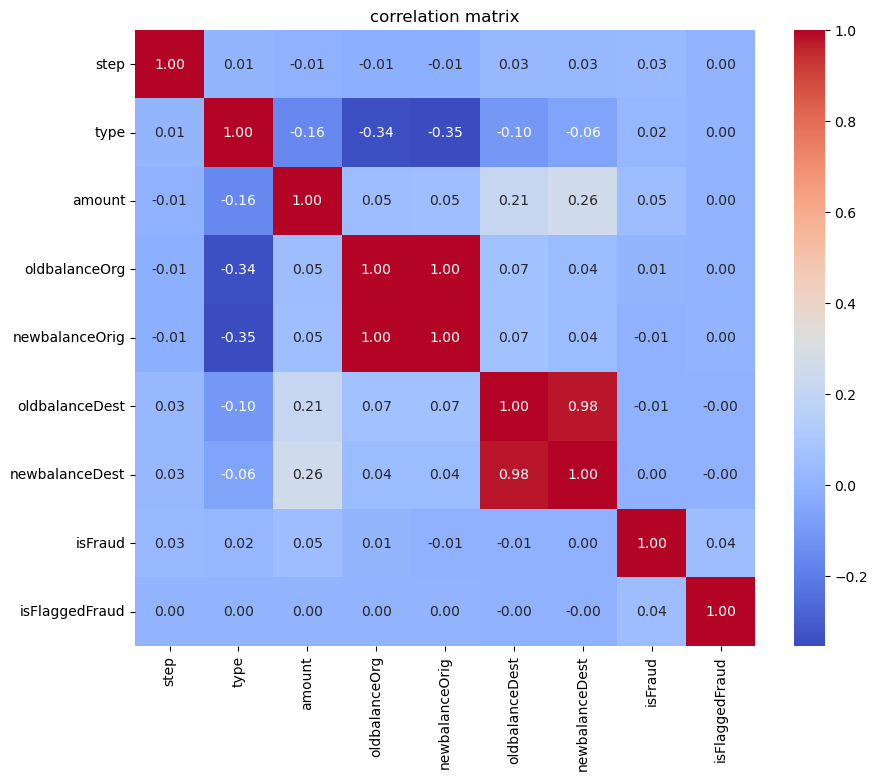

In [16]:
# multi collinearity 
# first check using the correlation matrix 
plt.figure(figsize=(10,8))
sns.heatmap(df.corr() , annot=True , cmap = 'coolwarm' , fmt=".2f")
plt.title("correlation matrix")
plt.show()

In [18]:
# as we can see from the matrix oldbalance and newbalance are highly related to each other but we will check 
# it using vif  
X_vif = df.drop(['isFraud', 'isFlaggedFraud'], axis=1)
X_vif = sm.add_constant(X_vif)
vif_data = pd.DataFrame()
vif_data['Feature'] = X_vif.columns
vif_data['VIF'] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
print(vif_data)

          Feature         VIF
0           const    7.794222
1            step    1.001123
2            type    1.297304
3          amount    1.178438
4   oldbalanceOrg  465.188834
5  newbalanceOrig  470.252519
6  oldbalanceDest   24.610471
7  newbalanceDest   25.090981


In [20]:
# very high multicollinearity in oldbalance and newbalance 
# we can combine and then remove highly collinear variables 
df['balanceOrig'] = df['oldbalanceOrg'] - df['newbalanceOrig']
df['balanceDest'] = df['newbalanceDest'] - df['oldbalanceDest']
# now remove earlier and recheck the VIF once again and see if done or not 
df.drop(['oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest'], axis=1, inplace=True)

X_vif = df.drop(['isFraud', 'isFlaggedFraud'], axis=1)
X_vif = sm.add_constant(X_vif)
vif_data = pd.DataFrame()
vif_data["Feature"] = X_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
print(vif_data)


       Feature       VIF
0        const  7.211819
1         step  1.000102
2         type  1.183937
3       amount  1.159808
4  balanceOrig  1.166318
5  balanceDest  1.174700


2. Model Elaboration 
    Model Used:
   
    Random Forest Classifier


In [27]:
# libraries for data spliting and model selection 

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve



x = df.drop(['isFraud', 'isFlaggedFraud'], axis=1)
y = df['isFraud']

# Split dataset
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, stratify=y, random_state=42)

# Train Random Forest with 100 trees 
model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
model.fit(x_train, y_train)


RandomForestClassifier(class_weight='balanced', random_state=42)

3.  Variables to be included in the model

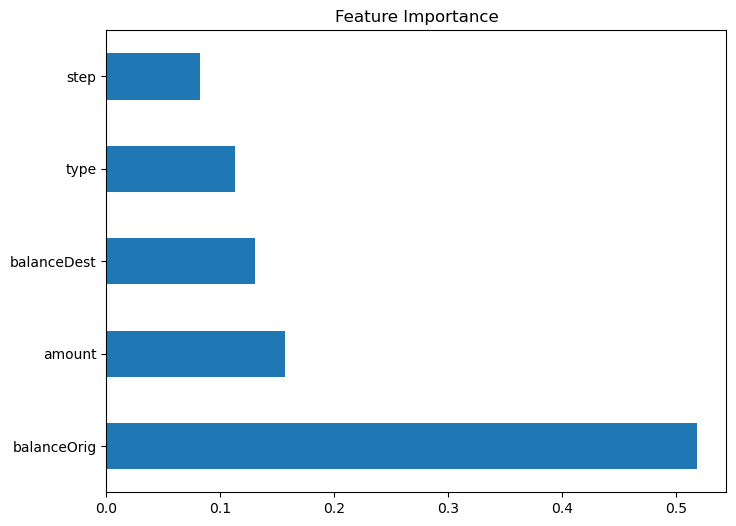

In [34]:
# Important Features from Random Forest
importances = pd.Series(model.feature_importances_, index=x.columns)
importances.sort_values(ascending=False).plot(kind='barh', figsize=(8,6))
plt.title("Feature Importance")
plt.show()


4. performance of the model 

[[1588556      46]
 [    537    1516]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1588602
           1       0.97      0.74      0.84      2053

    accuracy                           1.00   1590655
   macro avg       0.99      0.87      0.92   1590655
weighted avg       1.00      1.00      1.00   1590655

ROC-AUC Score: 0.9427648568467212


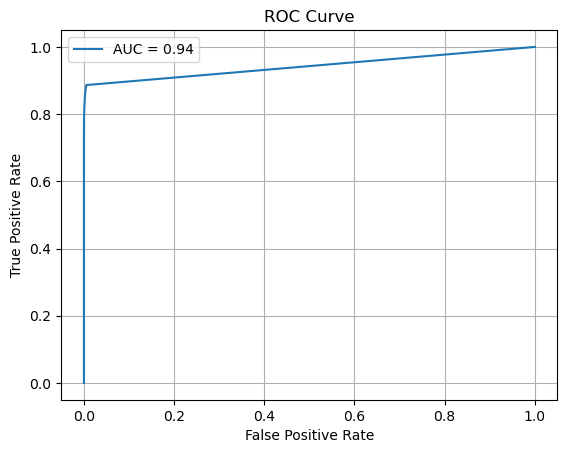

In [37]:
y_pred = model.predict(x_test)
y_proba = model.predict_proba(x_test)[:, 1]
# predict.proba returns the estimated probability of each class for a given input.
# Confusion Matrix and classification report
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# ROC-AUC Score
roc_auc = roc_auc_score(y_test, y_proba)
print("ROC-AUC Score:", roc_auc)

# ROC Curve
f_rate, t_rate, _ = roc_curve(y_test, y_proba)
plt.plot(f_rate, t_rate, label=f"AUC = {roc_auc:.2f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()


5.Key Factors Predicting Fraudulent Customers

In [40]:
key_factors = importances.sort_values(ascending=False).head(5)
print("key fraud predictors:\n", key_factors)


key fraud predictors:
 balanceOrig    0.518351
amount         0.156734
balanceDest    0.129955
type           0.112419
step           0.082541
dtype: float64


6. Do These Factors Make Sense

7. Infrastructure Recommendations for Prevention

8. How to Evaluate Post-Implementation Success